<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer_(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch to Fight Cancer

## 1. Data Augmentation

### What is Data Augmentation?

**Data augmentation** is a technique used in machine learning and deep learning to increase the diversity and amount of training data without actually collecting new data. This is achieved by applying various transformations to the existing data, creating modified versions of the original dataset. Common transformations include rotation, flipping, scaling, cropping, translating, and changing brightness or contrast.

### Purpose of Data Augmentation

The main purposes of data augmentation are:

1. **Preventing Overfitting**: By increasing the variability of the training data, models are less likely to memorize the training examples and more likely to generalize well to unseen data.
2. **Improving Model Robustness**: Augmented data can help models become more robust to different variations in real-world data.
3. **Compensating for Small Datasets**: In scenarios where acquiring a large dataset is difficult, data augmentation can artificially increase the dataset size.

### Intent of Using Data Augmentation in Deep Learning

In deep learning, data augmentation is crucial because:

- **Enhances Model Generalization**: Deep neural networks often require large amounts of data to generalize well. Data augmentation helps in providing a more comprehensive representation of the possible data variations.
- **Reduces the Need for Large Datasets**: Collecting large amounts of data can be expensive and time-consuming. Augmentation helps mitigate this issue by artificially expanding the dataset.

### Using Data Augmentation in TensorFlow

TensorFlow offers several ways to perform data augmentation, especially through the `tf.keras.preprocessing.image` module and the `tf.image` module. Below are some examples:

#### Using `ImageDataGenerator`

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming 'x' is a batch of images
augmented_images = datagen.flow(x, batch_size=32)
```

#### Using `tf.image`

```python
import tensorflow as tf

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image

# Assuming 'dataset' is a tf.data.Dataset of images
augmented_dataset = dataset.map(lambda x: augment_image(x))
```

### Using Data Augmentation in PyTorch

In PyTorch, data augmentation is typically done using the `torchvision.transforms` module. Below are examples of how to apply transformations:

```python
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

dataset = ImageFolder(root='path/to/dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
```

### Resources and Links

For more detailed information and tutorials on data augmentation, you can refer to the following resources:

1. **TensorFlow Documentation on Image Data Augmentation**: [TensorFlow Image Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
2. **PyTorch Documentation on Data Augmentation**: [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html)
3. **Comprehensive Guide on Data Augmentation Techniques**: [Towards Data Science - Data Augmentation](https://towardsdatascience.com/data-augmentation-techniques-in-python-745bc26a3665)

These resources will provide you with a deeper understanding of data augmentation techniques and how to implement them in TensorFlow and PyTorch.

### Setting our work environment

First, we check if GPU is connected. The `nvidia-smi` command (NVIDIA System Management Interface) is used to monitor and manage NVIDIA GPUs (Graphics Processing Units) in a system. It provides detailed information about the status and performance of the GPUs, including GPU utilization, temperature, memory usage, processes utilizing the GPU, and more.

**[`nvidia-smi`](https://www.baeldung.com/linux/nvidia-smi-full-gpu-details)** is a command-line utility provided by NVIDIA that helps you manage and monitor NVIDIA GPU devices. It stands for NVIDIA System Management Interface.

---
**Display Basic GPU Information**

---


In [10]:
!nvidia-smi

Mon Jun 17 15:25:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---
**Monitor GPU Usage Continuously**  `Beware infinity loop!!!!`

---

This command will update the GPU usage information every second. You can change the interval by replacing `1` with any other number of seconds.

In [11]:
!nvidia-smi -l 3

Mon Jun 17 15:25:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---
**Display Memory Usage**

---

This command will show the used and total memory of each GPU in a CSV format.

In [12]:
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv

memory.used [MiB], memory.total [MiB]
0 MiB, 15360 MiB


---
**List Processes Running on the GPU** `Beware infinity loop!!!!`

---

This command lists processes that are using the GPU, including their utilization.

In [13]:
!nvidia-smi pmon -s u

# gpu         pid  type    sm    mem    enc    dec    command
# Idx           #   C/G     %      %      %      %    name
    0          -     -      -      -      -      -    -              
    0          -     -      -      -      -      -    -              
    0          -     -      -      -      -      -    -              
    0          -     -      -      -      -      -    -              


---
**Set GPU Persistence Mode**

---

Persistence mode keeps the GPU driver loaded even when no applications are running, which can reduce the time to start new applications.

In [14]:
!nvidia-smi -i 0 -pm ENABLED


Enabled persistence mode for GPU 00000000:00:04.0.
All done.


and disabling...

In [15]:
!nvidia-smi --persistence-mode=0

Disabled persistence mode for GPU 00000000:00:04.0.
All done.


#### Additional Resources

- **NVIDIA Developer Documentation**: [NVIDIA System Management Interface Documentation](https://developer.nvidia.com/nvidia-system-management-interface)
  
- **NVIDIA Blog on GPU Management**: [Managing GPUs with NVIDIA-SMI](https://developer.nvidia.com/blog/managing-gpus-nvidia-smi/)

### Setting our workspace: `/content` and `/content/datasets`



---
**Setting our Home**

---

We save the root directory of the project '/content' as 'HOME' since we will be navigating through the directory to have multiple projects under the same HOME. Additionally, we will have the datasets in the 'datasets' directory, so all datasets are easily accessible for any project.

In [16]:
# Setting our $HOME to /content

import os
HOME = os.getcwd() # Obtain actual directory
print(HOME)

/content


Next, it imports the drive module from the google.colab library, which provides functionalities for mounting Google Drive in Google Colab.

Additionally, Google Drive is mounted in Google Colab and made available at the path /content/drive. The user will be prompted to authorize access to Google Drive. Once authorized, the content of Google Drive will be accessible from that point onwards in the Colab notebook.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load a dataset (dataloader)

Create the dataset directory (if it doesn't exist), where we are going to save the dataset with which we are going to train our CNN.

---
**Create a directory where we can save our dataset**

---

In [18]:
# Create the dataset directory
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


Check if the file specified by `file` does not exist in the current directory. If it doesn't exist, the code block inside the conditional, which in this case would be downloading the file from the specified URL, is executed. then, it extracts the contents of `exp0.zip` into the current directory quietly, overwriting any existing files if necessary.

---
**Change to new directory datasets**

---

In [19]:
# Change to new datsets folder and download the dataset
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp0.zip'):
  !wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets


### Inspect the Dataset

The dataset contains several thousand photos of cell images in two subdirectories (classes) with one cell image per class. The directory structure is as follows thanks to this snipet:

---
**Display the datapath structure.**

---

In [20]:
import os

def print_directory_tree(root_dir, level=0):
    """
    Recursively prints the directory tree structure, only listing directories.
    """
    prefix = " " * (level * 4) + "|-- " if level > 0 else ""
    print(prefix + os.path.basename(root_dir))

    if os.path.isdir(root_dir):
        for item in os.listdir(root_dir):
            item_path = os.path.join(root_dir, item)
            if os.path.isdir(item_path):
                print_directory_tree(item_path, level + 1)

# Define the data directory
data_dir = datasets_dir

# Print the directory tree
print_directory_tree(data_dir)

datasets
    |-- __MACOSX
        |-- exp0
            |-- val
                |-- class_0
                |-- class_1
            |-- train
                |-- class_0
                |-- class_1
            |-- test
                |-- class_0
                |-- class_1
    |-- exp0
        |-- val
            |-- class_0
            |-- class_1
        |-- train
            |-- class_0
            |-- class_1
        |-- test
            |-- class_0
            |-- class_1


Now, we will use the `matplotlib` library to display multiple images in a 2x4 grid layout. Next code imports necessary modules, including `matplotlib.pyplot` for plotting, `glob` for file matching, and `matplotlib.image` for image handling.

It specifies the directory containing the images and retrieves the paths of the first 8 `.jpg` images in that directory using `glob.glob()`.

Then, it creates a figure with subplots arranged in a 2x4 grid and iterates through the image paths, displaying each image in a subplot using `imshow()`. The title of each subplot is set to indicate the image index, and axis labels are turned off.

After displaying all images, it adjusts the layout to prevent overlapping and shows the figure.

Finally, it prints the size of the last image processed.

---
**Display 8 images from a class from test**

---

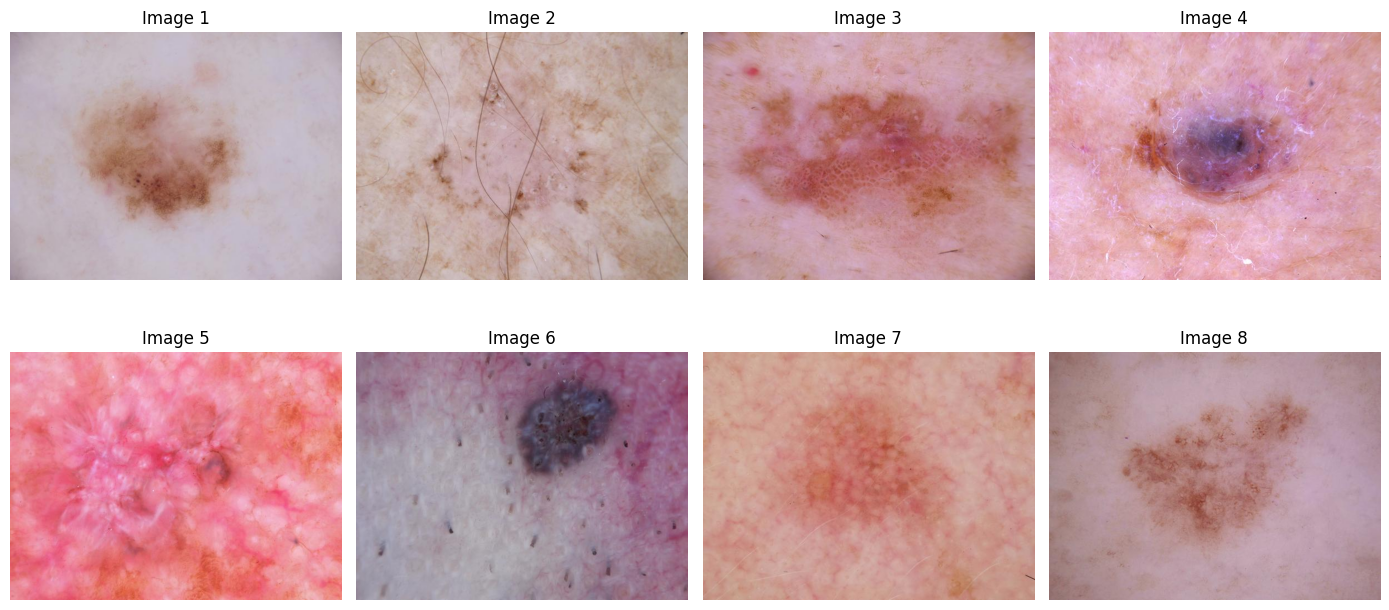


 Size of image:  (450, 600, 3)


In [21]:
# creates a figure with subplots arranged in a 2x4 grid
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'/content/datasets/exp0/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print("\n Size of image: ", img.shape)

### Setting a Dataloader

The purpose of a **DataLoader** is fundamental in the context of machine learning and deep learning, especially when working with large or complex datasets. Its main purpose is to facilitate the efficient loading and manipulation of data during model training.



---
**Load Libraries for DataLoader**

---

In [22]:
import torch
import torchvision
from torch.utils.data import DataLoader, ConcatDataset # CancatDataset is new
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar

In the context of data augmentation, `ConcatDataset` is a utility provided by PyTorch that allows you to concatenate multiple datasets into a single dataset. This can be particularly useful when you want to combine original datasets with augmented versions or when you want to merge different datasets to form a larger, more diverse training set.

### Purpose of `ConcatDataset` in Data Augmentation

1. **Combining Augmented and Original Data**: Often, you want to train a model on both the original dataset and the augmented versions of the dataset. `ConcatDataset` makes it easy to create a single dataset that includes both.

2. **Increasing Data Diversity**: By concatenating multiple datasets, you increase the variety of data your model is exposed to during training, which can help improve generalization.

3. **Efficient Data Management**: `ConcatDataset` allows for efficient management of multiple datasets without having to create separate data loaders for each. This can simplify the training pipeline.

### Additional Resources

- **PyTorch Documentation on `ConcatDataset`**: [ConcatDataset Documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.ConcatDataset)  
- **PyTorch Tutorials**: [PyTorch Tutorials](https://pytorch.org/tutorials/)

**Note**: These time magics (%time and %%time) will give you information about how long it takes to execute the code in the respective cell in Google Colab. The results will be displayed below the cell after the execution is completed.

---
**Create a Dataloader for train, val y test sets**

---

In [23]:
%%time

# 1. Calculate the mean and standard deviation on the training set.
# train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir  = "/content/datasets/exp0/test/"
test_dir   = "/content/datasets/exp0/val/"

# transform to calculate mean and standard desviation
transform = transforms.Compose([
    transforms.ToTensor()  # transform images to tensor
])

# Load the ImageFolder dataset and apply the transformation
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# it's better to use a loader to retrieve images (tensors)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to store the sum of pixel values and
# standard deviation.
# These variables are set to floating-point zeros to ensure
# accurate calculations.
mean_sum = 0.0
std_sum = 0.0
total_samples = 0

# Iterates over the data loader (loader),
# calculates the mean and standard deviation across all channels
# for each batch(0) and spatial dimensions (height(2) and width(3))
for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Total train samples:", total_samples)
print("Mean:", mean)
print("Std:", std)

Total train samples: 2700
Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])
CPU times: user 27.5 s, sys: 1 s, total: 28.5 s
Wall time: 28.6 s


---
**Transform the dataloaders for data augmentation**

---
- **Initial Transformations**: Various augmentation techniques like flipping, cropping, rotating, color jittering, affine transformations, blurring, and perspective changes are defined.  
- **Enhancing Transformations**: Each augmentation technique is enhanced by converting images to tensors and normalizing them.  
- **Final Output**: The list of transformations is updated and printed.

These transformations are typically applied during the training process to increase the diversity of the training data, helping to improve the generalization of the deep learning model.


In [24]:
# Define the data transformations to be applied
# to each transformed dataset
transformations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomPerspective(),
    #transforms.RandomErasing(p=0.5, scale=(1.0, 1.0), ratio=(1.0, 1.0),value='random'),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.2), ratio=(0.75, 1.33333333)),
]

# Add the ToTensor() and Normalize() transformation
# to each data transformation
for i in range(len(transformations)):
    transformations[i] = transforms.Compose([
        transformations[i],
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

print(transformations)

[Compose(
    RandomHorizontalFlip(p=0.5)
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomCrop(size=(64, 64), padding=4)
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None)
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0

---
**Normalize the dataloaders using Statistics**

---

- **Normalization**: Normalization is crucial for ensuring that pixel values across images are on a similar scale, which helps in stabilizing and speeding up the training process of deep neural networks.  
- **Dataset Preparation**: Each dataset (`train_data`, `val_set`, `test_set`) is prepared with consistent transformations and normalization, facilitating uniformity in data processing across training, validation, and testing phases.

This setup ensures that the datasets are properly preprocessed and ready to be used in training and evaluating machine learning models, particularly deep neural networks, using PyTorch.

In [25]:
%time

# 2. Normalize the training set using these statistics.
train_data = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# 3. Normalize the test and validation set using the same statistics
# calculated on the training set.
val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

print(f"Length of Train Data :{len(train_data)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_data.classes
print('Classes: ', classes)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Length of Train Data :2700
Length of Validation Data : 600
Length of Test Data : 300
Classes:  ['class_0', 'class_1']


The train set is unmodified in size because `transform()` transform the data but it don't augment the dataset

---
**Augment Data**

---

The train set is modified in size because `ConcatDataset()` augment the dataset.

In [26]:
# Apply each transformation separately to a transformed dataset
# and concatenate them.
train_set = train_data
for transform in transformations:
    transformed_data = datasets.ImageFolder(train_dir,transform = transform)
    train_set = ConcatDataset([train_set, transformed_data])

print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")


Length of Train Data :24300
Length of Validation Data : 600
Length of Test Data : 300


### Displaying all classes

Let us show one example for each class, for fun. As we've transformed the image by normalizing it, we should undo the transformation before visualizing the image.

---
**Display one example from each class**

---


CPU times: user 4.88 s, sys: 65.6 ms, total: 4.94 s
Wall time: 7.65 s


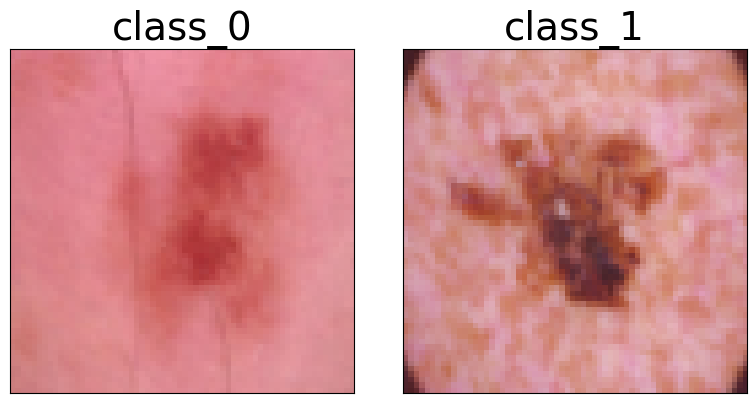

In [27]:
%%time
inv_normalize = transforms.Normalize(
  mean= [-m/s for m, s in zip(mean, std)],
  std= [1/s for s in std]
)

fig, ax = plt.subplots(nrows=1, ncols=len(classes), figsize=(2*4,1*4),
                       subplot_kw={'facecolor': "#ebf5ff"})

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[i], fontsize=28)
  img = next(img for img,label in train_set if label == i)
  #ax.imshow(img.permute(1,2,0)) # for normalized channels
  ax.imshow(inv_normalize(img).permute(1,2,0)) # for unnormalized

fig.tight_layout()


### Settings Hyperparameters

We are going to define some training parameters for the network, such as the number of batches, epochs, and classes in the dataset because they are needed for dataloaders in order to set up our training loop.

---
**Define batch_size, epochs and obtain the number of classes**

---

We will **run only 5 epochs** to check functionality. Later, we will load a model that has already been trained for 30 epochs.

In [28]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 32
# epochs define the number of iterations
epochs = 5
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


----
**Define the train and test loaders for the training loop**

---

In [29]:
%%time

# Create dataloaders object for training/val loop.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

CPU times: user 176 µs, sys: 12 µs, total: 188 µs
Wall time: 191 µs




Now, we define a function to obtain ncols and nrows need for a given number of images in order to display them.

---
**Define a small function to determine the columns and rows needed for a given number of images**

---

In [30]:
# We define a small function to determine the columns and rows needed
# for a given number of images.
def rows_cols(input):

    divisors = []

    # Realize a little operation with input
    # in order to determine divisors for input
    for i in range(1, input+1): # not divide by 0
        if input % i == 0:
            divisors.append(i)

    # divisors list size
    n = len(divisors)

    # If the size is odd, the element in the middle is the median value.
    if n % 2 != 0:
        median_index = (n - 1) // 2
        rows = divisors[median_index]
    # If the size is even, the two elements in the middle are equal
    else:
        median_index1 = n // 2 - 1
        rows = divisors[median_index1]

    cols = int(input/rows)
    return rows, cols


To see how the DataLoader works and how it handles the loaded data, we will select a random batch and display it, indicating its class label as well. It is said, we can display all images and its ground truth from a random batch in a easy way with dataloaders.

---
**Display all images and its ground truth from a random batch**

---

Alongside 'normal' images, we should observe transformed images.

CPU times: user 2.04 s, sys: 641 ms, total: 2.68 s
Wall time: 1min 53s


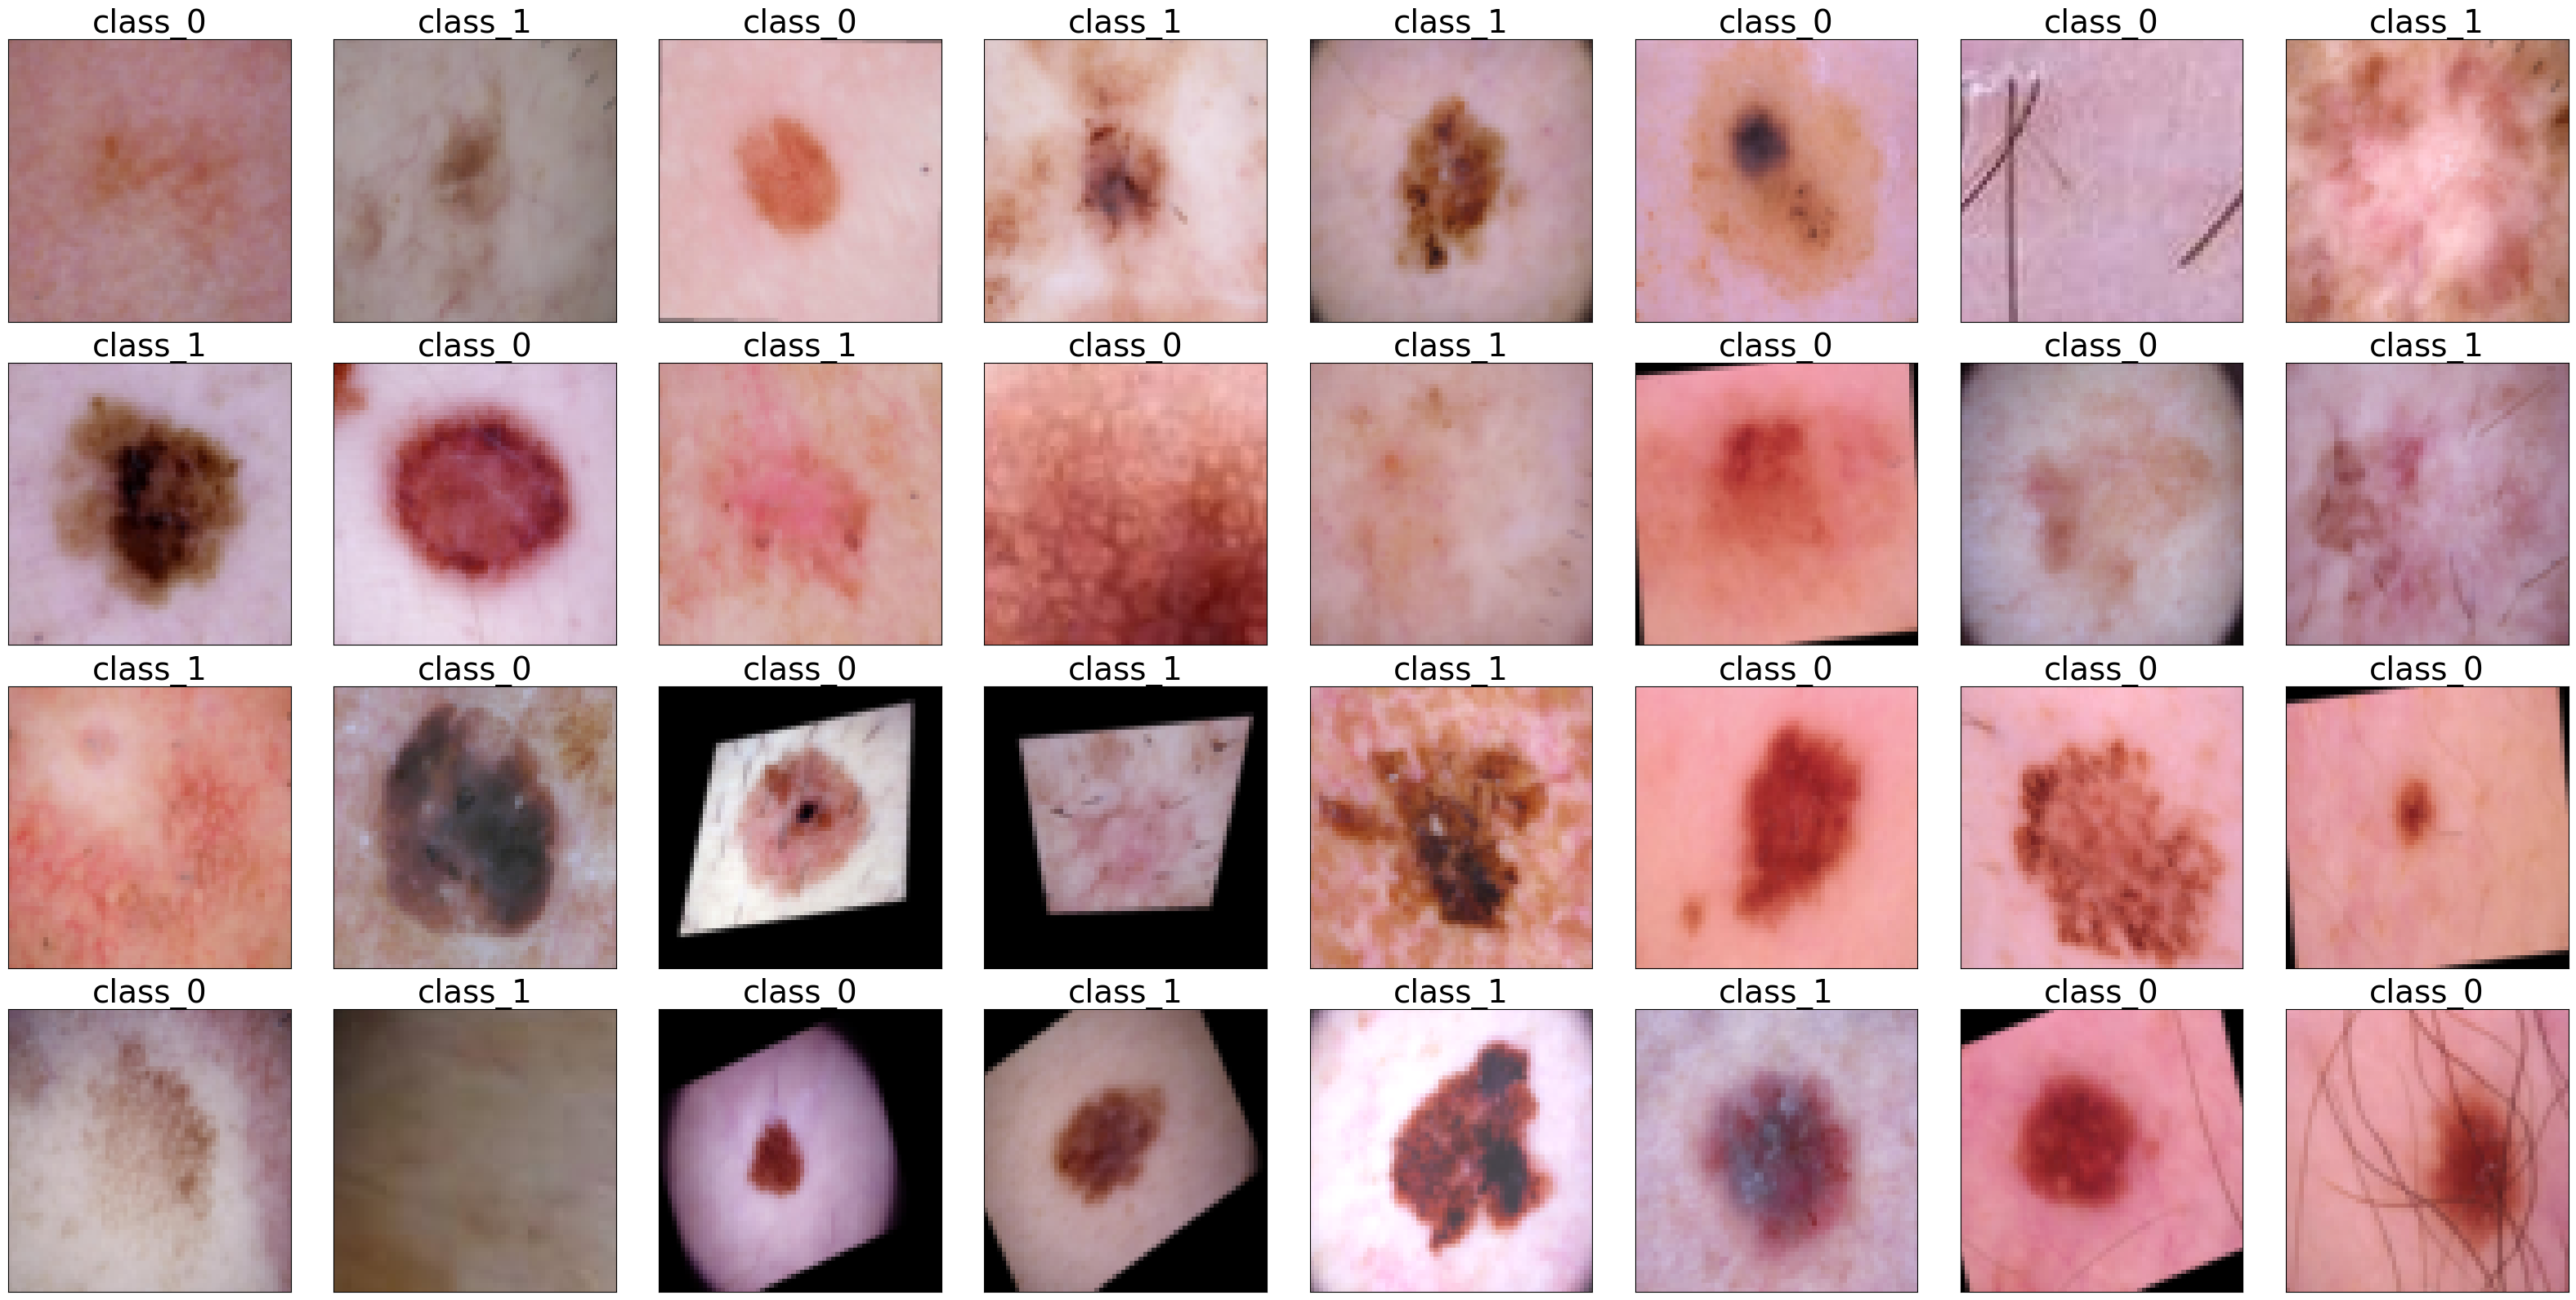

In [31]:
%%time

import itertools
import numpy as np
import os

nrows,ncols = rows_cols(batch_size)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),
                       subplot_kw={'facecolor': "#ebf5ff"})
rb_index = np.random.randint(0, len(train_dataloader))

# Obtener el batch correspondiente al índice aleatorio
imgs, labels = next(itertools.islice(train_dataloader, rb_index, rb_index+1))

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[labels[i]], fontsize=28)
  #ax.imshow(imgs[i].permute(1,2,0)) # for unnormalized
  ax.imshow(inv_normalize(imgs[i]).permute(1,2,0)) # for unnormalized

fig.tight_layout()

## 3. Define a [Convolutional Neural Network](https://pytorch.org/docs/stable/nn.html)

---
**import Libraries**

---


In [32]:
import torch.nn as nn
import torch.nn.functional as F

---
**Define the Model**

---

In [33]:
# Large Model
class myCNN(nn.Module):
    def __init__(self): # defines the constructor method __init__()
                        # for the myCNN class. This method is called
                        # when an instance of the class is created.
        super().__init__() # calls the constructor of the parent class
                           # (nn.Module) using Python's super() function.
                           # It initializes the parent class, allowing the
                           # myCNN class to inherit functionality from nn.Module.

        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )
    # The forward method takes a single argument xb,
    # which represents the input data to the neural network.
    # Inside the forward method, the input xb is passed through the
    # neural network layers defined in self.network. The result of this
    # computation is then returned as the output of the forward method.
    def forward(self, xb):
        return self.network(xb)

### Setting the Computing Device

This code sets up the device (CPU or GPU) for running the neural network and creates an instance of the `myCNN` model, moves it to the selected device, and optionally utilizes data parallelism if multiple GPUs are available.

Here's a detailed explanation of the code:

1. **Device Selection**: The code checks if CUDA (NVIDIA's parallel computing platform) is available on the system. If CUDA is available, the device is set to "cuda"; otherwise, it's set to "cpu". This allows the code to run on the GPU if available, which typically speeds up the training of neural network models.

2. **Model Creation**: An instance of the `myCNN` model is created. Then, the model is moved to the selected device using the `.to(device)` method. This ensures that all operations of the model are performed on the appropriate device (CPU or GPU).
= myCNN().to(device)

3. **Data Parallelism (Optional)**: If there's more than one GPU available (`torch.cuda.device_count() > 1`), a message indicating the number of available GPUs is printed, and `nn.DataParallel` is used to parallelize calculations across multiple GPUs. This automatically divides the data and operations in the network among the available GPUs, which can speed up model training in multi-GPU environments.

4. **Model Printing**: Finally, the model is printed, providing a detailed description of its architecture, including parameters and layers. This facilitates model verification and debugging.


In summary, this code prepares the model for training or inference on the selected device (CPU or GPU), and in case of multiple GPUs, allows data parallelism to speed up the training process.


Let's change the execution environment to T4.

---
**Setting CUDA environment**

---

>**NOTE:** Outside of Google Colab, it is necessary to explicitly specify the device (GPU or CPU) and manage model parallelization if using multiple GPUs. This is crucial to ensure the model runs on the intended GPU and leverages the available hardware effectively. While Google Colab manages GPU allocation automatically, specifying the device ("cuda") and using `nn.DataParallel` can still be beneficial for explicit control and utilization of available resources, especially if you have specific requirements or want to ensure optimal performance. However, for many basic use cases, simply  letting Colab manage the resources with automatic GPU selection) will suffice.

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = myCNN().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)

Using cuda device
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear



---
**Display the summary of our model**

---

In [35]:
!pip install torchsummary -q

from torchsummary import summary

summary(model, (3,64,64)) # input = [3,64,64]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

### Define a Loss function and optimizer




---

**Define a Loss Function and a Optimizer**

---


In [36]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
# Define your optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 4. Train the network


Let's see the number of training images we have and how many batches we'll use in each epoch.

---
**Number of images and batches**

---

In [37]:
print (f"Train dataset size={len(train_dataloader.dataset)}") #number of images from dataset
print (f"Number of batches={len(train_dataloader)}") # number of images/batch_size (or number of batches)

Train dataset size=24300
Number of batches=760


### Defining Training Loop

---
**Defining train**

---

In [38]:
def train(dataloader, model, criterion, optimizer):
  running_loss, corrects, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  print(f"Training:")
  model.train() #training mode on
  loop = tqdm(train_dataloader) # Initialize a progress bar
  for batch, (X, y) in enumerate(loop):
    # take data (X) and label (y) from a batch
    X, y = X.to(device), y.to(device) # Move the data and labels
                                      # to the device (CPU or GPU)

    # forward pass
    preds = model(X) # Compute predictions
    loss = criterion(preds, y) # Compute the loss between predictions and labels

    # backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()         # compute gradients to backwards
    optimizer.step()        # Does the "update weights" of model

    # Calculate Output Metrics training_loss, training_accuracy

    # 1. loss.item() contains the loss of entire mini-batch converted to scalar
    running_loss += loss.item() # Accumulate the loss for this batch

    # 2. current image (last image in the batch) for progressive bar
    current += len(X) # Update the current number of processed images

    # 3. From the predictions, I select the index (class) of the one with
    # the highest value and compare it with the label (class). The boolean value
    # is converted into a float (true becomes 1, false becomes 0), and all are
    # summed up. Finally, 'item' converts them into a scalar value.
    # This way, 'corrects' reflects the number of correct predictions (accuracy)
    corrects += (preds.argmax(1) == y).type(torch.float).sum().item()

    # 4. running loss is the sum of our loss. Training loss is a running average
    # through batches
    training_loss = running_loss/(batch+1)

    # 5. Training accuracy = number of corrects predictions/number of processed images
    training_accuracy = corrects/current

    # Update the progress bar with current epoch, batch, and metrics
    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')
    loop.set_postfix(Training_Loss=training_loss, Accuracy=f'{100*corrects/current:>0.1f}%')

  return training_loss, training_accuracy

---
**Defining val**

---

In [39]:
def val(dataloader, model, criterion):
  size = len(dataloader.dataset) # number images from dataset to evaluate
  num_batches = len(dataloader)  # number of batches

  # Evaluation (test)) Mode
  model.eval()

  val_loss, corrects = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # prediction for a dataset not used in training
      # compute prediction error and number of corrects
      # through batches
      preds = model(X)
      val_loss += criterion(preds, y).item()
      corrects += (preds.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  corrects /= size
  print(f"Test: \n Accuracy: {(100*corrects):>0.1f}%, val_Loss: {val_loss:>8f} \n")

  return val_loss, corrects

---
**Defining training loop**

---

In [40]:
%%time

import csv

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

for epoch in range(epochs): # Iterates over each epoch and performs training and evaluation.
  # Train the model on the training data and saves
  #the training loss and accuracy for the current epoch
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)

  # Evaluate the model on the test data and saves
  # the test loss and accuracy for the current epoch.
  loss_test,acc_test= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_test)
  accuracy_val_history.append(acc_test)

print("Done!. Finished Training")

# Saves the training and test loss, as well as the training and test accuracy,
# for each epoch to a CSV file named "metrics_myCNN.csv".
print("Saving model and metrics!.")
# Save the metrics to a CSV file.
with open('metrics_myCNN_daug.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])
    for epoch, (train_loss, train_accuracy, val_loss, val_accuracy) in enumerate(zip(loss_train_history, accuracy_train_history, loss_val_history, accuracy_val_history)):
        writer.writerow([epoch+1, train_loss, train_accuracy, val_loss, val_accuracy])

# Saves the trained model's state dictionary to a file named "myCNN.pth".
#torch.save(model.state_dict(), "myCNN.pth")

torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, "myCNN_daug.pth")

print("Model and metrics saved!.")

Training:


[1/5 epochs, 24300/24300 data]: 100%|██████████| 760/760 [02:45<00:00,  4.58it/s, Accuracy=50.3%, Training_Loss=0.693]


Test: 
 Accuracy: 65.3%, val_Loss: 0.692957 

Training:


[2/5 epochs, 24300/24300 data]: 100%|██████████| 760/760 [02:37<00:00,  4.83it/s, Accuracy=52.1%, Training_Loss=0.693]


Test: 
 Accuracy: 49.5%, val_Loss: 0.692695 

Training:


[3/5 epochs, 24300/24300 data]: 100%|██████████| 760/760 [02:39<00:00,  4.77it/s, Accuracy=54.5%, Training_Loss=0.692]


Test: 
 Accuracy: 71.0%, val_Loss: 0.691157 

Training:


[4/5 epochs, 24300/24300 data]: 100%|██████████| 760/760 [02:38<00:00,  4.79it/s, Accuracy=66.0%, Training_Loss=0.678]


Test: 
 Accuracy: 71.0%, val_Loss: 0.592417 

Training:


[5/5 epochs, 24300/24300 data]: 100%|██████████| 760/760 [03:10<00:00,  3.99it/s, Accuracy=69.1%, Training_Loss=0.573]


Test: 
 Accuracy: 71.7%, val_Loss: 0.542027 

Done!. Finished Training
Saving model and metrics!.
Model and metrics saved!.
CPU times: user 1min 40s, sys: 6.84 s, total: 1min 47s
Wall time: 14min 1s


---
**Displaying the metrics curves model (only 5 epochs)**

---

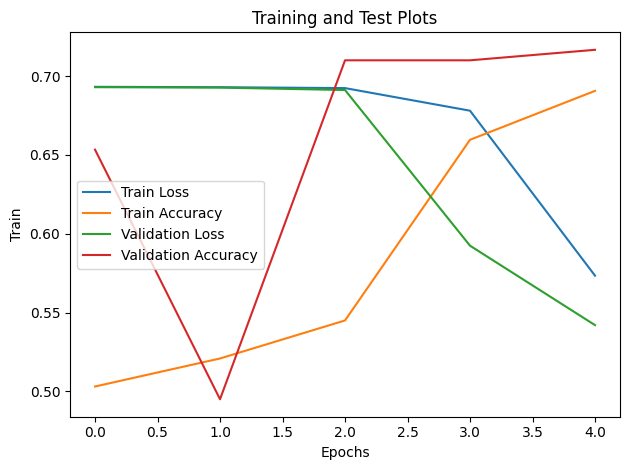

In [41]:
fig, ax = plt.subplots()

ax.set_title('Training and Test Plots')
ax.plot(range(epochs), loss_train_history, label="Train Loss")
ax.plot(range(epochs), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epochs), loss_val_history, label="Validation Loss")
ax.plot(range(epochs), accuracy_val_history, label="Validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

---
**Loading a 30 epochs model previously training**

---

Where am I?

In [42]:
import os
os.chdir('/content')
HOME = os.getcwd()
print(HOME)
datasets_dir = os.path.join(HOME, "datasets")
print(datasets_dir)

/content
/content/datasets


---
**Upload files from local**

---

metrics_myCNN_daug.csv

myCNN_daug.pth

In [43]:
from google.colab import files
import shutil
import os

# To upload files from your local machine
uploaded = files.upload()

# Listar los archivos cargados y moverlos al directorio /content
for filename in uploaded.keys():
    print(f'File loaded: {filename}')
    source_path = f'{filename}'
    destination_path = datasets_dir+f'/{filename}'
    shutil.move(source_path, destination_path)

# To check the contents of the directory /content
print("Directory contents /content/datsets:")
os.listdir(datasets_dir)

Saving metrics_myCNN_daug.csv to metrics_myCNN_daug.csv
Saving myCNN_daug.pth to myCNN_daug.pth
File loaded: metrics_myCNN_daug.csv
File loaded: myCNN_daug.pth
Directory contents /content/datsets:


['__MACOSX', 'exp0', 'myCNN_daug.pth', 'exp0.zip', 'metrics_myCNN_daug.csv']

Once the file is uploaded, you can load the model and optimizer state from the file.

---
**Load the model previously saved**

---

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv

# define the model
# Large Model
class myCNN(nn.Module):
    def __init__(self): # defines the constructor method __init__()
                        # for the myCNN class. This method is called
                        # when an instance of the class is created.
        super().__init__() # calls the constructor of the parent class
                           # (nn.Module) using Python's super() function.
                           # It initializes the parent class, allowing the
                           # myCNN class to inherit functionality from nn.Module.

        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )
    # The forward method takes a single argument xb,
    # which represents the input data to the neural network.
    # Inside the forward method, the input xb is passed through the
    # neural network layers defined in self.network. The result of this
    # computation is then returned as the output of the forward method.
    def forward(self, xb):
        return self.network(xb)

# Mover el modelo al dispositivo adecuado después de cargar el estado
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = myCNN().to(device)
# Verificar si se está usando nn.DataParallel y reconfigurar si es necesario
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

# Definir el criterio de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# Cargar el checkpoint
checkpoint = torch.load(datasets_dir+"/myCNN_daug.pth", map_location=device)

# Restaura el estado del modelo
model.load_state_dict(checkpoint['model'])

# Restaura el estado del optimizador
optimizer.load_state_dict(checkpoint['optimizer'])



print("Model and optimizer loaded successfully.")
print(model)

Using cuda device
Model and optimizer loaded successfully.
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bia

---
**Displaying the metrics curves from a saved model**

---

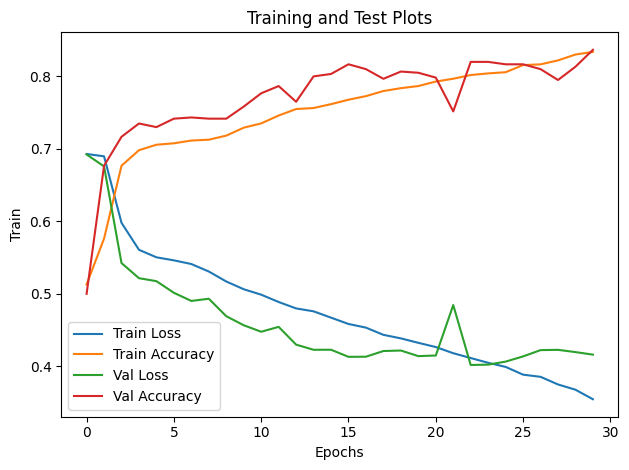

In [45]:
import csv
import matplotlib.pyplot as plt

#
epochs = []
loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []
with open(datasets_dir+'/metrics_myCNN_daug.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        epochs.append(int(row['Epoch']))
        loss_train_history.append(float(row['Train Loss']))
        accuracy_train_history.append(float(row['Train Accuracy']))
        loss_val_history.append(float(row['Val Loss']))
        accuracy_val_history.append(float(row['Val Accuracy']))
    epochs=len(epochs)

fig, ax = plt.subplots()

ax.set_title('Training and Test Plots')
ax.plot(range(epochs), loss_train_history, label="Train Loss")
ax.plot(range(epochs), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epochs), loss_val_history, label="Val Loss")
ax.plot(range(epochs), accuracy_val_history, label="Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()


## Validating our model



Validation with a validation dataset is a common practice in machine learning model development and is crucial for building models that generalize well to new, unseen data.

---
**Validation Metrics**

---

In [46]:
# Supongamos que tienes tu modelo entrenado y los conjuntos de datos divididos
val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)


import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Define una función para obtener las predicciones del modelo
def obtener_predicciones(modelo, dataloader):
    preds = []
    etiquetas = []
    for batch in dataloader:
        inputs, etiquetas_batch = batch
        inputs = inputs.to(device)  # Si estás utilizando GPU, mueve los datos a la GPU
        outputs = modelo(inputs)
        _, predicciones = torch.max(outputs, 1)
        preds.extend(predicciones.tolist())
        etiquetas.extend(etiquetas_batch.tolist())
    return preds, etiquetas

# Define el dispositivo (CPU o GPU) en el que se realizarán las operaciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo guardado
model_file = datasets_dir+"/myCNN_daug.pth"
checkpoint = torch.load(model_file, map_location=device)
model_state_dict = checkpoint['model']

# Supongamos que 'val_dataloader' es tu DataLoader de validación

# Definir y cargar el modelo
# Asegúrate de definir tu modelo adecuadamente
model = myCNN()
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# Obtén las predicciones del modelo y las etiquetas verdaderas del conjunto de validación
predicciones_val, etiquetas_val = obtener_predicciones(model, val_dataloader)

# Calcular la matriz de confusión
cm = confusion_matrix(etiquetas_val, predicciones_val)

# Extraer los valores de la matriz de confusión
tn, fp, fn, tp = cm.ravel()

# Imprimir los valores
print("Verdaderos negativos (TN):", tn)
print("Falsos positivos (FP):", fp)
print("Falsos negativos (FN):", fn)
print("Verdaderos positivos (TP):", tp)


Verdaderos negativos (TN): 233
Falsos positivos (FP): 67
Falsos negativos (FN): 31
Verdaderos positivos (TP): 269


---
**Get confusion metrics**

---

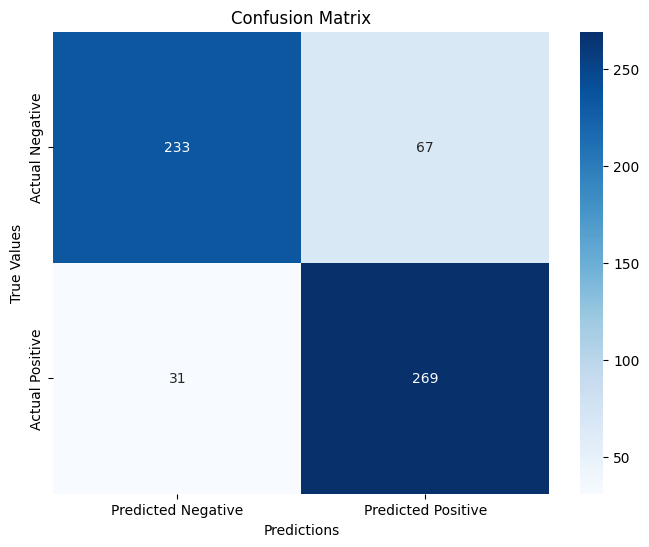

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'etiquetas_val' are the true labels and 'predicciones_val' are the model predictions

# Calculate the confusion matrix
cm = confusion_matrix(etiquetas_val, predicciones_val)

# Create a Pandas DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()



---
**Display the Classification Report**

---

In [48]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(etiquetas_val, predicciones_val)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.88      0.78      0.83       300
           1       0.80      0.90      0.85       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



---

**Display a ROC curve**

---


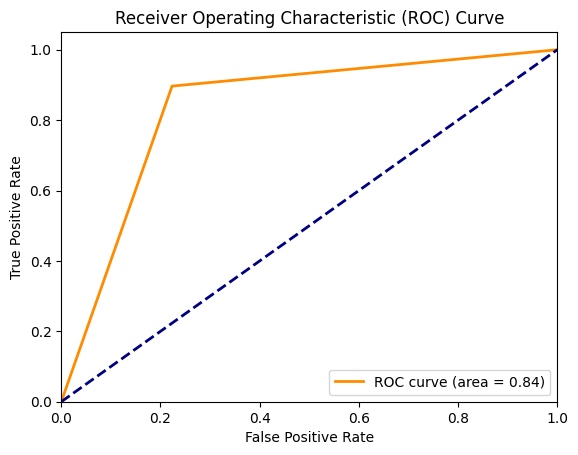

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Supongamos que 'predicciones_val' y 'etiquetas_val' son las predicciones y etiquetas verdaderas del conjunto de validación
# Obtenidas previamente usando la función obtener_predicciones()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(etiquetas_val, predicciones_val)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## `Exercise`

---
Modify the notebook as necessary to improve the performance parameters of a model you create. Try to use a metric that combines the partial metrics to show that your model classifies better than the baseline model shown in this notebook. What you can modify includes:

---

### Instructions to Improve the Notebook (invest about it by yourself and use some of them or all):

ChatGPT can be your great allied. Use it for your convenence.

1. **Data Preprocessing**: Improve data preprocessing by normalizing the data, handling missing values. You should use Transforms.

2. **Model Architecture**: Modify the architecture of the model. Experiment with different layers, activation functions, or network structures.

3. **Training Parameters**: Tune the training parameters such as learning rate, batch size, number of epochs, and optimization algorithms (e.g., Adam, SGD).

4. **Regularization Techniques**: Apply regularization techniques like dropout, L1/L2 regularization to prevent overfitting.

5. **Data augmentation**. Try different transformations and you don't forget concat the data augmentation. Remember the problems of google colab with T4 you don't abuse about it.